In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})
import glob
from scipy.signal import medfilt,butter
import scipy
import math

In [15]:
n_splits = 10
all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [16]:
shimfiles = glob.glob('shimmerData/*/*')

In [17]:
def get_shimmer(subjno, part, epochno):
    epoch = num_to_epoch(epochno)
    if epoch == 'REC':
        epoch = 'Rec'
    elif epoch == 'P1':
        epoch = '_P1'
    elif epoch == 'P2':
        epoch = '_P2'
    
    for file in shimfiles:
        if str(subjno) in file and part in file and epoch in file:
            data = pd.read_csv(file, header = None)
    try:
        vectors = np.asarray(data[[1,2,3]])
    except:
        print('mising shimmer data. skipping...')
        return np.repeat(np.nan, 1000)
    mean = np.mean(vectors, axis = 0)
    std = np.std(vectors, axis = 0)
    
    vectors = (vectors - mean[np.newaxis,:])

    #plt.plot(vectors)
    
    z_vector = np.linalg.norm(vectors, axis = 1)

    return z_vector


In [18]:
def get_split_shimmer(subjno, part, epochno, splitno):

    z_vector = get_shimmer(subjno,part,epochno)

    return np.array_split(z_vector,n_splits)[splitno]


In [19]:
def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)        
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime])

def spectrum_statistics(signal):
    
    fs,pxx = sig.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
    
#     plt.plot(fs,pxx)
    #plt.xlim(0,0.1)

    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))

    # Add wavelet analysis

    return [peak, peakmag, integral, energy, shannon]

In [28]:
test_signal = get_shimmer(42, 'body', 3)

In [59]:
def max_dists(signal, m):
    count = 0
    N = len(signal)
    max_dists = []
    while count < N-m-1:
        x_i = signal[count:count+m-1]
        x_j = signal[count+1:count+m]
        max_dists.append(scipy.spatial.distance.chebyshev(x_i, x_j))
        count += 1
    return max_dists


def approx_entropy(signal):
    N = len(signal)
    m = 2 #or 3 -- dimensionality? 
    r = 0.3
        
    
    def phi(m):
        d_func = max_dists(signal,m)
        C = []
        for i in d_func:
            if i <= r and i > 0:
                C.append(i/(N-m+1)) 
        return (N - m + 1.0)**(-1) * sum(np.log10(C))
    return (abs(phi(m)-phi(m+1)))


approx_entropy(test_signal)

0.2766343281788908

In [64]:

def sample_entropy(signal):
    N = len(signal)
    m = 2
    r = 0.2
    
    A_list = max_dists(signal,m+1)
    B_list = max_dists(signal,m)
    
    count_A = 0
    count_B = 0
    for i in A_list:
        if i < r:
            count_A += 1
    for i in B_list: 
        if i < r:
            count_B += 1
    if count_B == 0:
        return np.nan
    return math.log10(count_A/count_B)*-1

print(sample_entropy(test_signal))

0.009862868702608938


In [61]:
def multiscale_entropy(signal):
    mses = []
    for T in range(2,20,2):
        coarse_grain = []
        i = 0
        while i < len(signal):
            new_val = sum(signal[i:i+T])/T
            coarse_grain.append(new_val)
            i += T
        mses.append(sample_entropy(coarse_grain))
    return np.mean(mses)
        
print(multiscale_entropy(test_signal))



0.024643562693091963


In [65]:
bfeatures = [];
n_splits = 1
targets = [];
allfeatures = []
hfeatures = [];

for subjno in tqdm(all_subjects):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            bshim_signal = get_split_shimmer(subjno,'body',epoch,splitno)
            if bshim_signal[0] is np.nan:
                continue;
            bfeature = np.stack((approx_entropy(bshim_signal), sample_entropy(bshim_signal), \
                                      multiscale_entropy(bshim_signal)))
            bfeatures.append(bfeature)

            hshim_signal = get_split_shimmer(subjno,'head',epoch,splitno)
            if bshim_signal[0] is np.nan:
                continue;
            hfeature = np.stack((approx_entropy(hshim_signal), sample_entropy(hshim_signal), \
                                      multiscale_entropy(hshim_signal)))
            hfeatures.append(hfeature)

            targets.append(is_perturbed(epoch))
            allfeature = np.concatenate((bfeature,hfeature))
            allfeatures.append(allfeature)

allfeature_names = ['b_approx_entropy', 'b_sample_entropy', 'b_multiscale_entropy', \
                   'h_approx_entropy', 'h_sample_entropy', 'h_multiscale_entropy']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)










  0%|          | 0/33 [00:00<?, ?it/s]







  3%|▎         | 1/33 [00:51<27:41, 51.91s/it]







  6%|▌         | 2/33 [01:43<26:46, 51.83s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










  9%|▉         | 3/33 [02:09<22:04, 44.14s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 12%|█▏        | 4/33 [02:35<18:41, 38.66s/it]







 15%|█▌        | 5/33 [03:27<19:56, 42.73s/it]







 18%|█▊        | 6/33 [04:19<20:28, 45.50s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 21%|██        | 7/33 [04:20<13:51, 32.00s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 24%|██▍       | 8/33 [04:59<14:10, 34.02s/it]







 27%|██▋       | 9/33 [05:53<16:01, 40.07s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 30%|███       | 10/33 [06:19<13:46, 35.93s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 33%|███▎      | 11/33 [06:46<12:12, 33.28s/it]

mising shimmer data. skipping...










 36%|███▋      | 12/33 [07:37<13:31, 38.63s/it]







 39%|███▉      | 13/33 [08:29<14:09, 42.50s/it]







 42%|████▏     | 14/33 [09:21<14:21, 45.33s/it]







 45%|████▌     | 15/33 [10:15<14:24, 48.00s/it]







 48%|████▊     | 16/33 [11:11<14:19, 50.57s/it]







 52%|█████▏    | 17/33 [12:09<14:00, 52.53s/it]







 55%|█████▍    | 18/33 [13:04<13:19, 53.31s/it]







 58%|█████▊    | 19/33 [13:59<12:33, 53.79s/it]







 61%|██████    | 20/33 [14:52<11:35, 53.53s/it]







 64%|██████▎   | 21/33 [15:45<10:43, 53.61s/it]







 67%|██████▋   | 22/33 [16:36<09:40, 52.81s/it]







 70%|██████▉   | 23/33 [17:30<08:51, 53.15s/it]







 73%|███████▎  | 24/33 [18:29<08:13, 54.86s/it]







 76%|███████▌  | 25/33 [19:26<07:25, 55.64s/it]







 79%|███████▉  | 26/33 [20:23<06:30, 55.79s/it]







 82%|████████▏ | 27/33 [21:25<05:46, 57.78s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...










 85%|████████▍ | 28/33 [21:53<04:03, 48.69s/it]

mising shimmer data. skipping...










 88%|████████▊ | 29/33 [22:51<03:26, 51.53s/it]







 91%|█████████ | 30/33 [23:50<02:41, 53.77s/it]







 94%|█████████▍| 31/33 [24:44<01:47, 53.91s/it]







 97%|█████████▋| 32/33 [25:38<00:54, 54.06s/it]







100%|██████████| 33/33 [26:34<00:00, 48.32s/it]


In [86]:
targets = np.asarray(targets)
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

In [109]:
where = ~(np.asarray(np.sum(np.isnan(fdf),1)) > 0)

In [111]:
fdf_clean = fdf.iloc[where]
targets_clean = targets[where]

In [112]:
unpert = targets[where] == 0
pert = targets[where] == 1

In [113]:
pvals = [];

for measure in fdf_clean.columns:
    unpert_measure = np.asarray(fdf_clean.iloc[unpert][measure])
    pert_measure = np.asarray(fdf_clean.iloc[pert][measure])
    pvals.append(stats.wilcoxon(unpert_measure, pert_measure).pvalue)

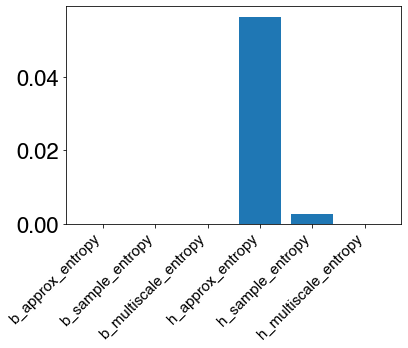

In [115]:
plt.bar(fdf.columns,height=pvals)
plt.xticks(rotation=45, ha='right',fontsize=15);

In [123]:
import statsmodels.stats.multitest as multitest

In [205]:
bonf05 = multitest.multipletests(pvals, alpha = 0.05, method = 'bonferroni')[0]
bonf01 = multitest.multipletests(pvals, alpha = 0.01, method = 'bonferroni')[0]
bonf1 = multitest.multipletests(pvals, alpha = 0.1, method = 'bonferroni')[0]

In [206]:
aster_n = bonf05.astype(int) + bonf01.astype(int) + bonf1.astype(int)

In [210]:
def n_to_str(n):
    if n == 0:
        return ''
    if n == 1:
        return '*'
    if n == 2:
        return '**'
    if n == 3:
        return '***'

In [211]:
u_means = np.mean(fdf_clean[unpert], 0)
u_stds = stats.sem(fdf_clean[unpert], 0)
p_means = np.mean(fdf_clean[pert], 0)
p_stds = stats.sem(fdf_clean[pert], 0)

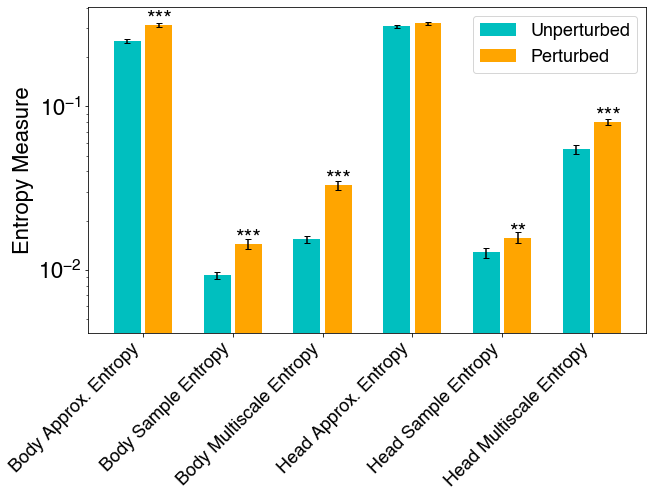

In [224]:
plt.figure(figsize = (10,6))
idx = np.arange(len(fdf.columns))
width = 0.3
plt.bar(idx, height = u_means, yerr = u_stds, log = True, width = width, capsize = 3, color = 'c',\
       label = 'Unperturbed');
plt.bar(idx + width + 0.05, height = p_means, yerr = p_stds, log = True, width = width, capsize = 3, \
        color = 'orange', label = 'Perturbed');

labels = ['Body Approx. Entropy', 'Body Sample Entropy', 'Body Multiscale Entropy',\
             'Head Approx. Entropy', 'Head Sample Entropy', 'Head Multiscale Entropy']
plt.xticks(idx+0.5*(width + 0.05), labels, rotation=45, ha='right',fontsize=18);

for ii in range(len(fdf.columns)):
    plt.text(idx[ii] + width + .05, p_means[ii], n_to_str(aster_n[ii]), ha = 'center');

plt.legend(fontsize = 18)
plt.ylabel('Entropy Measure')

plt.savefig('entropy_measures.pdf', bbox_inches = 'tight')